In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import QuantTrading.BackTest as BT
import matplotlib.pyplot as plt
import QuantTrading.SyntheticAlpha as SA
from tqdm import tqdm
import seaborn as sns
plt.style.use("ggplot")
%config InlineBackend.figure_format='retina'

def load_from_pickle(filename):
    path = '../pkl_dump/' # it mean the folder is in the same directory as the notebook
    with open(path + filename, 'rb') as f:
        return pickle.load(f)

# load model parameters
def load_from_impact_pickle(filename):
    path = 'impact_model_summary/' # it mean the folder is in the same directory as the notebook
    with open(path + filename, 'rb') as f:
        return pickle.load(f)

# Load data
traded_volume_df = load_from_pickle('traded_volume_df.pkl')
px_df = load_from_pickle('px_df.pkl') # price dataframe
daily_stock_info_df = load_from_pickle('daily_stock_info_df.pkl')
monthly_scaling_factor = load_from_pickle('monthly_scaling_factor.pkl')
stocks = traded_volume_df.reset_index()["stock"].unique()

# load model fitting results
ow_summary = load_from_impact_pickle('ow_summary.pkl')
afs_summary = load_from_impact_pickle('afs_summary.pkl')


## Helper Function

In [10]:
def impact_state(traded_volume_df, monthly_scaling_factor, half_life, model_type):
    """
    obtain the impact state I_t by ewma method, need to choose model type
    linear: OW model; sqrt: 
    """
    # space kernels
    space_kernels = {
        "linear": lambda x: x,
        "sqrt": lambda x: np.sign(x) * np.sqrt(np.abs(x)),
    }

    beta = np.log(2) / half_life
    time_unit = 10  # 10 seconds
    decay_factor = np.exp(-beta * time_unit)
    pre_ewm = traded_volume_df
    pre_ewm = pre_ewm.divide(monthly_scaling_factor["volume"], axis="rows")
    

    
    #pre_ewm = pre_ewm.divide(monthly_scaling_factor["ave daily volume"], axis="rows")
    pre_ewm = space_kernels[model_type](pre_ewm)
    pre_ewm = pre_ewm.multiply(monthly_scaling_factor["px_vol"], axis="rows")
    #pre_ewm = pre_ewm.multiply(monthly_scaling_factor["price volatility"], axis="rows")

    pre_ewm.iloc[:, 1:] /= (1 - decay_factor)
    cum_impact = pre_ewm.ewm(alpha=1-decay_factor, adjust=False, axis="columns").mean()  # Across columns
    return cum_impact

def impact_adjusted_prices(pre_ewm, px_df, scaling_df, half_life, impact_coef_df, model_type):
    """
    P(t) -> S(t)
    calculate the adjusted prices after removing the impact
    inputs:
    pre_ewm: impact state
    px_df: price dataframe
    scaling_df: scaling factor dataframe, where scaling factor is the average daily volume
    half_life: half life of the impact, typically 3600
    impact_coef_df: impact coefficient dataframe where we need beta_estimate
    model_type: linear or sqrt
    """
    cum_impacts = impact_state(pre_ewm, scaling_df, half_life, model_type).T # cumulative impact
    cum_returns = px_df.T / px_df.T.iloc[0, :] - 1 # cumulative returns
    stock_date_df = cum_returns.T.iloc[:, 0].reset_index()
    # stock_date_df["month"] = pd.to_datetime(stock_date_df["date"]).dt.month
    stock_date_df.drop(["date"], axis="columns", inplace=True)
    # merge the impact coefficients
    impact_coefficients = pd.merge(stock_date_df, impact_coef_df, on=["stock"], how="left")["beta_estimate"].values
    cum_returns -= cum_impacts * impact_coefficients # adjusted returns by removing impact
    adjusted_px_df = (px_df.T.iloc[0, :] * (cum_returns + 1)).T.reset_index() # get price from returns
    return adjusted_px_df

def strategy_adjusted_prices(pre_ewm, adjusted_px_df, scaling_df, decay_factor, impact_coef_df, kernel):
    """
    S(t) -> P(t) by adding the impact of the strategy
    adjusts the prices based on the impacts of a trading strategy, considering decay factors, scaling, and kernel effects
    inputs:
        pre_ewm: trade volume dataframe
        adjusted_px_df: fundamental price dataframe S(t)
        scaling_df: scaling factor dataframe, contain px_vol and volume
        decay_factor: decay factor, or beta
        impact_coef_df: impact coefficient dataframe
        kernel: kernel function
    """
    pre_ewm_copy = pre_ewm.copy()
    pre_ewm_copy = kernel(pre_ewm_copy)
    pre_ewm_copy.iloc[:, 1:] /= (1 - decay_factor)
    cum_impacts = pre_ewm_copy.ewm(alpha=1-decay_factor, adjust=False).mean()
    scaler_df = pd.merge(cum_impacts.T.iloc[:, 0], scaling_df, on=["stock", "date"])
    cum_impacts *= (scaler_df["px_vol"] / kernel(scaler_df["volume"])).values
    cum_returns = adjusted_px_df.T / adjusted_px_df.T.iloc[:, 0] - 1
    stock_date_df = cum_returns.T.iloc[:, 0].reset_index()
    stock_date_df.drop(["date"], axis="columns", inplace=True)
    impact_coefficients = pd.merge(stock_date_df, impact_coef_df, on=["stock"], how="left")["beta_estimate"].values
    cum_returns += cum_impacts * impact_coefficients
    strategy_adjusted_px_df = (adjusted_px_df.T.iloc[:, 0] * (cum_returns + 1)).T.reset_index()
    return strategy_adjusted_px_df

def impact_resultant_prices(trades, prices, decay, impact_coef, kernel, price_vol, ADV):
    """
    S(t)-> P(t), more general it only need the trades and prices
    adjusts prices based on the impacts of a trading strategy, taking into account the decay factor, scaling, and kernel effects.
    inputs:
        trades: trade dataframe
        prices: price dataframe S(t)
        decay: decay factor, or beta
        impact_coef: impact coefficient, lambda
        kernel: kernel function
        price_vol: price volatility
        ADV: average daily volume
    """
    trades_copy = trades.copy()
    trades_copy = kernel(trades_copy)
    if len(np.shape(trades_copy)) == 1:
        trades_copy[1:] /= (1 - decay)
    else:
        trades_copy.iloc[:, 1:] /= (1 - decay) # divide by decay factor
    # calculate the impact of such trade strategy by the beta from the impact coefficient
    cum_impacts = trades_copy.ewm(alpha=1-decay, adjust=False).mean() # I(t) = (1 - decay) * I(t-1) + decay * I(t)
    cum_impacts *= price_vol / kernel(ADV) # multiply by price volatility and divide by kernel of ADV
    cum_returns = prices / prices[0] - 1
    cum_returns += cum_impacts * impact_coef
    return prices[0] * (cum_returns + 1)

# kernel
def sqrt_kernel(values):
    return np.sqrt(np.abs(values)) * np.sign(values)

def linear_kernel(values):
    return values

# trade & pnl
def backtest(trades, intended_impacts, prices):
    """
    trades: array of trades
    intended_impacts: intended impacts for the trades
    prices: price dataframe
    """
    Qs = trades.cumsum()  # trade position is cumsum of trade
    # Integral Q_tdS_t
    fundamental_gain = (prices.T.pct_change(1).T * Qs.shift(-1)).T
    # integral I_t dQ_t
    impact_cost = -intended_impacts * trades.shift(-1)
    pnls = (fundamental_gain.unstack() + impact_cost).fillna(0).cumsum().T
    return pnls

def pnl_metrics(pnls, trades, impact_coef):
    """
    calculate the pnl metrics, pnls is already cumulative sum
    """
    # obtain pnl per day from cumulative pnls
    daily_pnls = pnls.diff(1).fillna(0)

    # calculate expected daily PnL
    expected_daily_pnl = daily_pnls.mean()

    # calculate the sharpe ratio
    sharpe_ratio = daily_pnls.mean() / daily_pnls.std() * np.sqrt(252)

    # calculate transaction costs
    transaction_costs = (trades * impact_coef).sum()

    # calculate the max drawdown as in pct
    cumulative_pnls = daily_pnls.cumsum()
    max_drawdown = (cumulative_pnls.cummax() - cumulative_pnls).max()

    # calculate the max impact dislocation
    max_impact_dislocation = pnls.abs().max()

    return expected_daily_pnl, sharpe_ratio, transaction_costs, max_drawdown, max_impact_dislocation

# Plotting P&L
def plot_pnl(daily_pnls, stock, date):
    cumulative_pnls = daily_pnls.cumsum()
    cumulative_pnls = cumulative_pnls.droplevel(0)
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_pnls, label="Cumulative P&L", color='orange')
    plt.title(f"Cumulative P&L for {stock} on {date}")
    plt.xlabel("Time")
    plt.ylabel("Cumulative P&L")
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_histogram(daily_pnls):
    plt.figure(figsize=(12, 6))
    sns.histplot(daily_pnls, kde=True, color='blue')
    plt.title("Distribution of Daily P&L")
    plt.xlabel("Daily P&L")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_drawdown(daily_pnls):
    cumulative_pnls = daily_pnls.cumsum()
    drawdown = cumulative_pnls.cummax() - cumulative_pnls
    drawdown = drawdown.droplevel(0)
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown, label="Drawdown", color='red')
    plt.title("Drawdown Over Time")
    plt.xlabel("Time")
    plt.ylabel("Drawdown")
    plt.legend()
    plt.grid(True)
    plt.show()

def print_summary_table(metrics):
    metrics_df = pd.DataFrame(metrics, index=["Metrics"])
    print(metrics_df)

## Analysis

In [11]:
def pnl_metrics(pnls, trades, impact_coef):
    """
    calculate the pnl metrics, pnls is already cumulative sum
    """
    # obtain pnl per day from cumulative pnls
    daily_pnls = pnls.diff(1).fillna(0)

    # calculate expected daily PnL
    expected_daily_pnl = daily_pnls.mean()

    # calculate the sharpe ratio
    sharpe_ratio = daily_pnls.mean() / daily_pnls.std() * np.sqrt(252)

    # calculate transaction costs
    transaction_costs = (trades * impact_coef).sum()

    # calculate the max drawdown as in pct
    cumulative_pnls = daily_pnls.cumsum()
    max_drawdown = (cumulative_pnls.cummax() - cumulative_pnls).max()

    # calculate the max impact dislocation
    max_impact_dislocation = pnls.abs().max()

    return expected_daily_pnl, sharpe_ratio, transaction_costs, max_drawdown, max_impact_dislocation

# specify parameters
stock = "AAPL"
date = "2019-06-06"
half_life = 3600
corr = 0.6 # correlation between alpha and return
corrs = [0.1, 0.6, 0.9]  # correlation between alpha and return
model_types = ["linear", "sqrt"]  # model types
alpha_horizons = [6, 12, 30]  # look ahead horizon
alpha_horizon = 6 # look ahead horizon, 6 = 1 min
time_unit = 10  # 10 seconds
beta = np.log(2) / half_life # determine beta through required half life
decay_factor = np.exp(-beta * time_unit)
px_vol, ADV = monthly_scaling_factor.loc[stock, date]
model_type = "linear" # specify model type for optimal trade

# Obtain alpha and optimal trades
alphas_series = SA.get_synthetic_alpha(corr, px_df, stock, alpha_horizon=alpha_horizon, smooth=True).loc[date][200:]
optimal_trades = BT.get_optimal_trades(monthly_scaling_factor, alphas_series, ow_summary, stock, date, model_type)
pct_synthetic_alpha_optimal_trades = optimal_trades / ADV

# Compute adjusted prices
px_df2 = impact_adjusted_prices(traded_volume_df.copy(), px_df, monthly_scaling_factor, half_life, ow_summary, "linear")
prices = px_df2.loc[(px_df2["stock"] == stock) & (px_df2["date"] == date)].iloc[:, 202:] # given stock and date, transpose
intended_impacts = 1/2 * (alphas_series - alphas_series.diff(1).shift(-1).fillna(0) / beta / time_unit)
intended_impacts.iloc[-1] = alphas_series.iloc[-1] # I_T^* = \alpha_T

impact_resultant_price = impact_resultant_prices(optimal_trades, prices.values[0], decay_factor, ow_summary.loc[stock, "beta_estimate"], linear_kernel, px_vol, ADV)

# Backtest and compute performance metrics
pnls = backtest(optimal_trades, intended_impacts, prices)
expected_daily_pnl, sharpe_ratio, transaction_costs, max_drawdown, max_impact_dislocation = pnl_metrics(pnls, optimal_trades, ow_summary.loc[stock, "beta_estimate"])

# Print results
print("Expected Daily P&L:", expected_daily_pnl)
print("Sharpe Ratio:", sharpe_ratio)
print("Transaction Costs:", transaction_costs)
print("Max Daily Drawdown:", max_drawdown)
print("Max Impact Dislocation:", max_impact_dislocation)



# Plotting
#plot_pnl(pnls, stock, date)

# Plotting
daily_pnls = pnls.diff(1).fillna(0)
#plot_pnl(daily_pnls, stock, date)
#plot_histogram(daily_pnls)
#plot_drawdown(daily_pnls)



/Users/reds/Desktop/QuantTradingProject-main/QuantTrading/SyntheticAlpha.py:15: FutureWarning: Support for axis=1 in DataFrame.ewm is deprecated and will be removed in a future version. Use obj.T.ewm(...) instead
  return synthetic_alphas.ewm(halflife=200, axis="columns").mean()
<ipython-input-10-08b45b03cf32>:26: FutureWarning: Support for axis=1 in DataFrame.ewm is deprecated and will be removed in a future version. Use obj.T.ewm(...) instead
  cum_impact = pre_ewm.ewm(alpha=1-decay_factor, adjust=False, axis="columns").mean()  # Across columns


Expected Daily P&L: -1.7187409888270604
Sharpe Ratio: -0.17500796618350037
Transaction Costs: -19279871.192670733
Max Daily Drawdown: 14944.519846981226
Max Impact Dislocation: 9310.249277543555


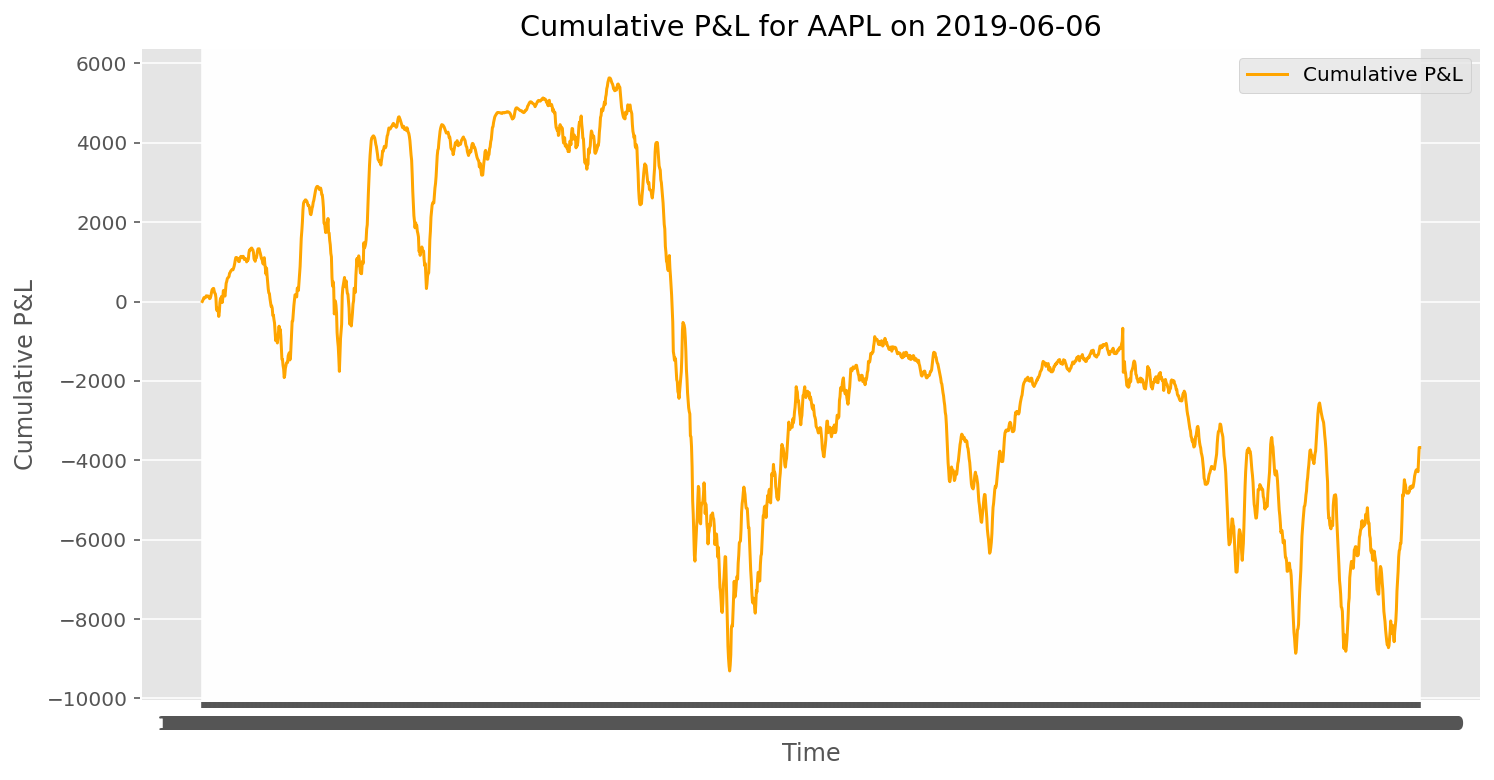

In [12]:
plot_pnl(daily_pnls, stock, date)

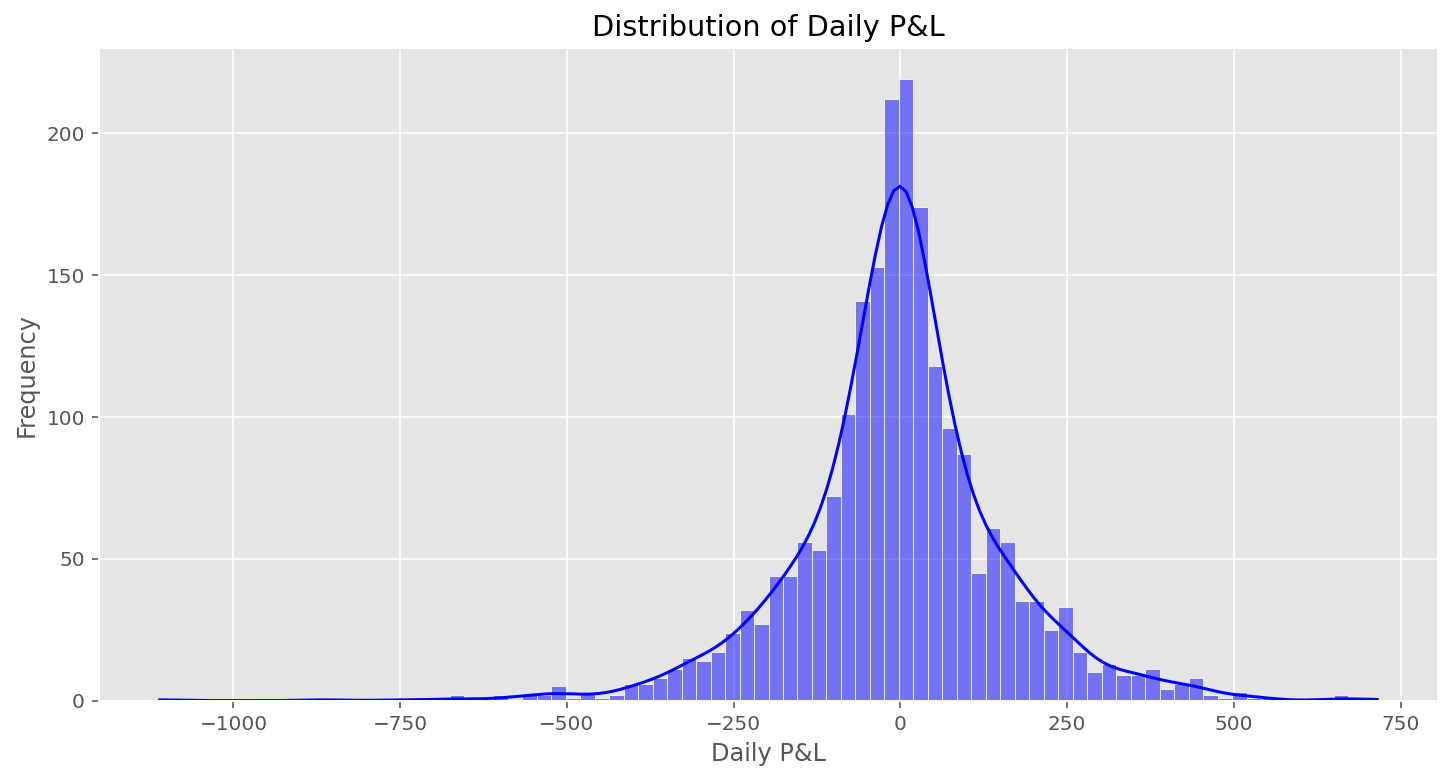

In [13]:
plot_histogram(daily_pnls)

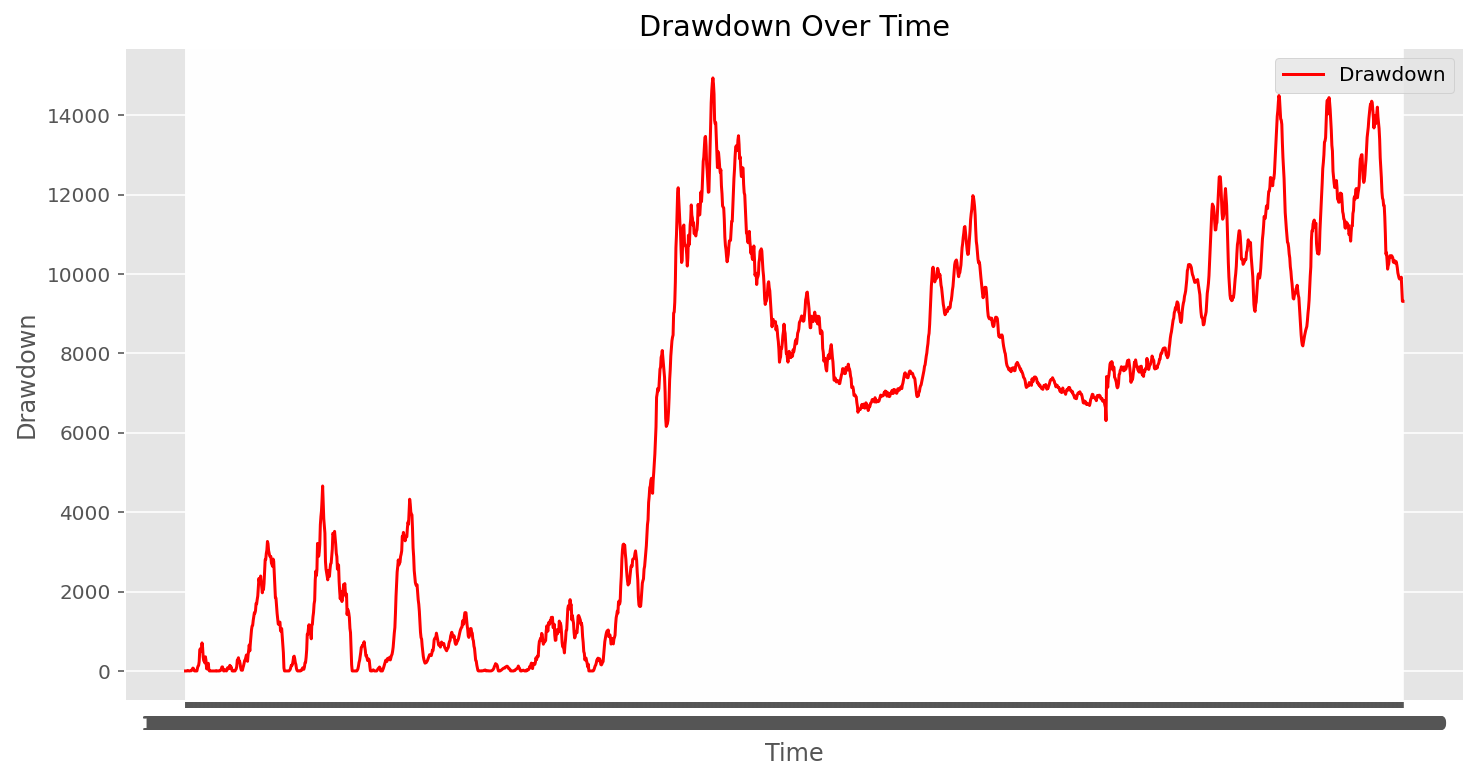

In [14]:
plot_drawdown(daily_pnls)

In [15]:
# Print summary table
metrics = {
    "Expected Daily P&L": expected_daily_pnl,
    "Sharpe Ratio": sharpe_ratio,
    "Transaction Costs": transaction_costs,
    "Max Daily Drawdown": max_drawdown,
    "Max Impact Dislocation": max_impact_dislocation
}
print_summary_table(metrics)

         Expected Daily P&L  Sharpe Ratio  Transaction Costs  \
Metrics           -1.718741     -0.175008      -1.927987e+07   

         Max Daily Drawdown  Max Impact Dislocation  
Metrics        14944.519847             9310.249278  
